# Network-Analysis-for-Information-Retrieval

## Data 

In [2]:
import pandas as pd
from random import seed
import warnings

warnings.filterwarnings('ignore')
seed(3052000)

FILE_PREFIX = "dblp-ref-"
NB_FILES = 4

corpus = []

# Load all the files into a single dataframe
# for i in range(0, NB_FILES):
#     file = './data/' + FILE_PREFIX + str(i) + ".json"
#     data = pd.read_json(file, lines=True)
#     corpus.append(data)

# Load the lightest file
file = './data/' + FILE_PREFIX + '3' + ".json"
data = pd.read_json(file, lines=True)
corpus.append(data)

corpus = pd.concat(corpus, ignore_index=True)

In [3]:
import numpy as np

#On remplace les valeurs manquantes par des listes vides
for index, row in corpus.iterrows():
    if type(row['references']) != list:
        corpus.at[index, 'references'] = []

#Affichage des valeurs manquantes
print("Number of NAN references", corpus['references'].isna().sum())

Number of NAN references 0


In [4]:
#Remplacer les identifiants des références par les identifiants existants du corpus
for index, row in corpus.iterrows():
    for ref_index, ref in enumerate(row['references']):
        random_index = index
        while random_index == index:
            random_index = np.random.randint(0, corpus.shape[0])
        row['references'][ref_index] = corpus['id'].iloc[random_index]

In [5]:
corpus.shape

(79007, 8)

----- Abstracts -----
Mean length of Abstracts 1060.5378252168111
Max length of Abstracts 7139.0
Min length of Abstracts 60.0


----- Authors -----
Number of authors 282514
Number of unique authors 178268
Mean number of papers per author 1.5847712432966097
Number of paper per author : authors
Wei Wang                92
Yang Yang               54
Mohamed-Slim Alouini    53
Jun Wang                52
Wei Zhang               52
                        ..
Patrice Koehl            1
Saghi Nojoomi            1
Wataru Noguchi           1
Atulan Zaman             1
Eirik Abildsnes          1
Name: count, Length: 178268, dtype: int64


----- Temporal distribution -----


<Axes: >

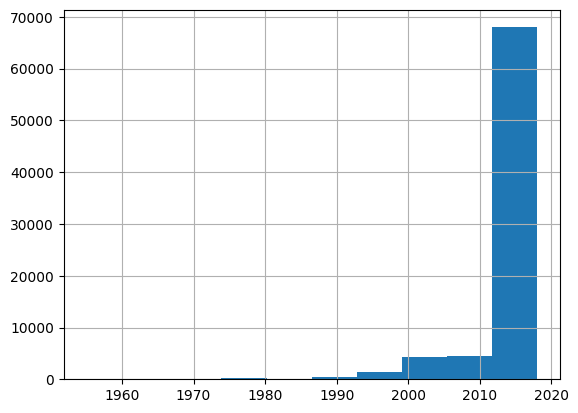

In [6]:
#Quelques statistiques sur le corpus
print("----- Abstracts -----")
print("Mean length of Abstracts", corpus['abstract'].str.len().mean())
print("Max length of Abstracts", corpus['abstract'].str.len().max())
print("Min length of Abstracts", corpus['abstract'].str.len().min())

print("\n")
print("----- Authors -----")
df_exploded = corpus.explode('authors')
print("Number of authors", len(df_exploded['authors']))
unique_authors = df_exploded['authors'].unique().tolist()
print("Number of unique authors", len(unique_authors))
print("Mean number of papers per author", df_exploded['authors'].value_counts().mean())
print("Number of paper per author :", df_exploded['authors'].value_counts())

print("\n")
print("----- Temporal distribution -----")
corpus['year'].hist(bins=10)

## Networks

In [7]:
import mpld3
import itertools
import networkx as nx
import matplotlib.pyplot as plt

NB_NODES = 2000 # nombre de nœuds à afficher en raison du grand nombre de nœuds

### Authorship Network

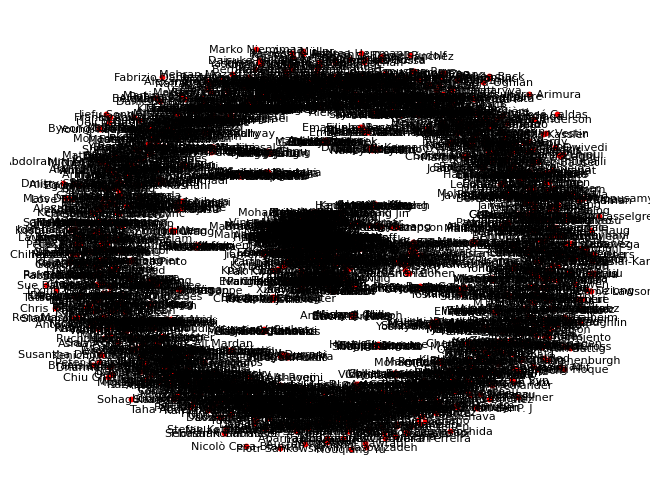

In [8]:
# Affichage du graphe
mpld3.enable_notebook()

G = nx.Graph()

for authors_list in corpus['authors']:
    G.add_nodes_from(authors_list)
    G.add_edges_from(itertools.combinations(authors_list, 2))

nodes_to_keep = list(G.nodes())[:NB_NODES]
G_filtered = G.subgraph(nodes_to_keep)

pos = nx.spring_layout(G_filtered)
nx.draw(G_filtered, pos, with_labels=True, node_size=10, node_color='red', font_size=8)

import matplotlib.pyplot as plt
plt.show()

mpld3.disable_notebook()

#### Statistical Analysis

In [9]:
#Statistiques liées au graphe des auteurs
print("Number of connected components : ", nx.number_connected_components(G_filtered))
print("Total degree : ", sum(dict(G_filtered.degree()).values()))
print("Average clustering : ", round(nx.average_clustering(G_filtered), 2))
print("Transitivity : ", round(nx.transitivity(G_filtered), 2))
print("Number of nodes : ", G_filtered.number_of_nodes())
print("Number of edges : ", G_filtered.number_of_edges())

Number of connected components :  497
Total degree :  6638
Average clustering :  0.82
Transitivity :  0.93
Number of nodes :  2000
Number of edges :  3319


#### Degree Distribution

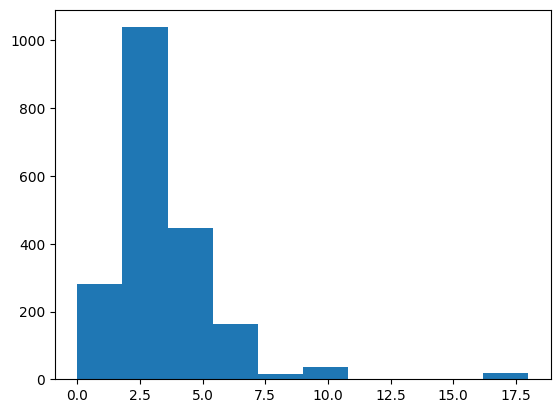

In [10]:
G_filtered.degree()
d_degree = dict(G_filtered.degree())
n, bins, patches = plt.hist(d_degree.values())
plt.show() #la majorité des auteurs ont un degré faible

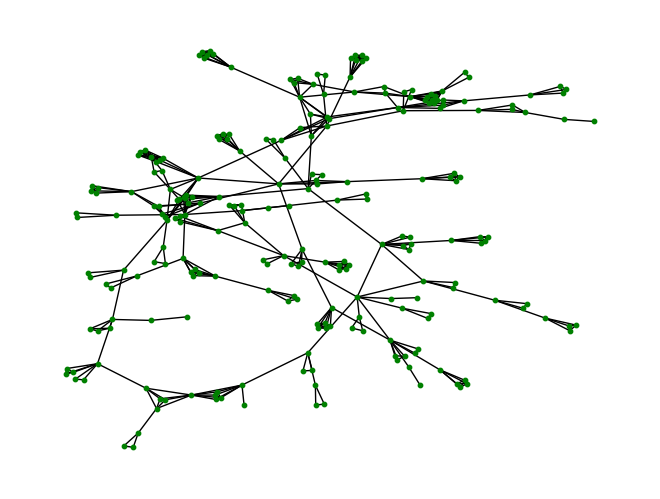

In [11]:
#Affichage du plus grand composant connexe
g_sorted = sorted(nx.connected_components(G_filtered), key=len, reverse=True)

g = G_filtered.subgraph(g_sorted[0])
pos = nx.spring_layout(g)
nx.draw(g, pos, with_labels=False, node_size=10, node_color='green', font_size=8)
plt.show()

#### Centrality Measures

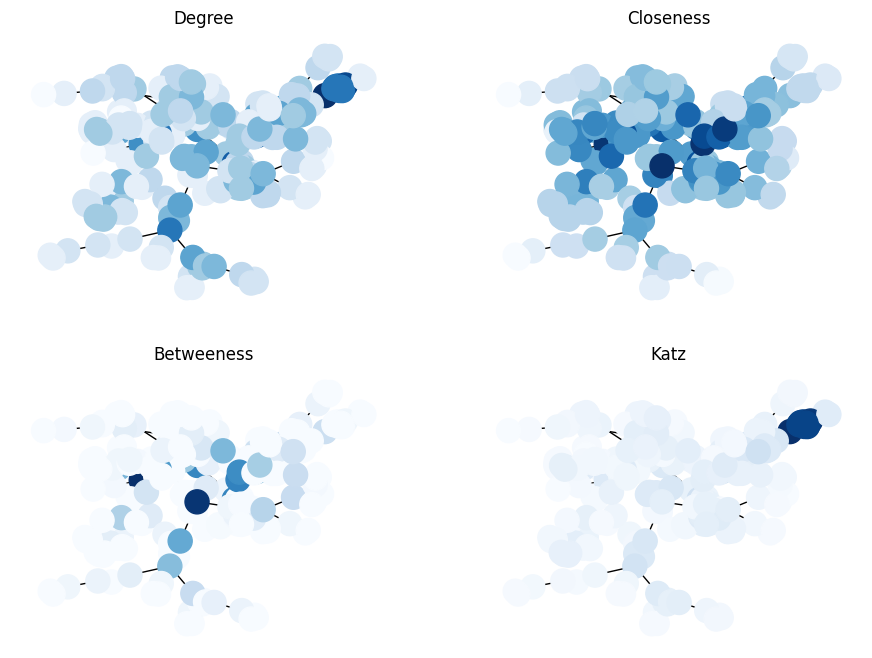

In [12]:
#On affiche les centralités des noeuds du graphe des auteurs
centralities = [nx.degree_centrality, nx.closeness_centrality, nx.betweenness_centrality, nx.katz_centrality]
centralities_names = ["Degree", "Closeness", "Betweeness", "Katz"]
val_cent = []

for c in centralities:
    val_cent.append(c(g))

my_pos = nx.spring_layout(g)

figure = plt.figure(figsize=(11, 8))
for i in range(len(centralities)):
    figure.add_subplot(2, 2, i+1)
    plt.title(centralities_names[i])
    nx.draw(g, pos = my_pos, with_labels=False, node_color=[*val_cent[i].values()], cmap=plt.cm.Blues)
plt.show() 

### Document Network

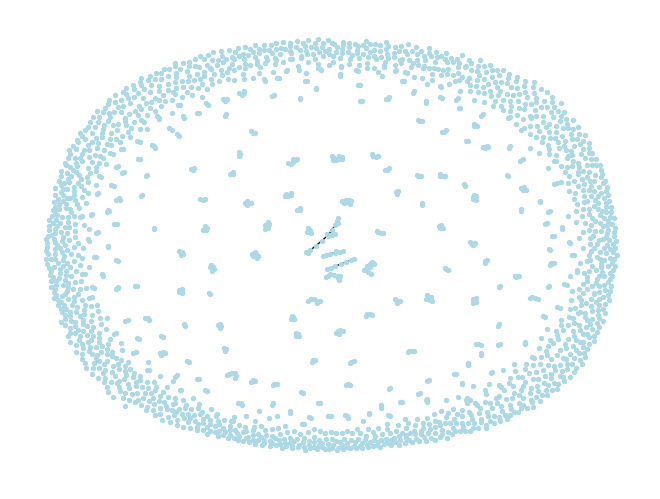

In [13]:
#On affiche le graphe des articles
G = nx.Graph()

for index, row in corpus.iterrows():
    G.add_node(row['id'])

for index, row in corpus.iterrows():
    for ref in row['references']:
        if ref in G.nodes():
            G.add_edge(row['id'], ref)
    

nodes_to_keep = list(G.nodes())[:NB_NODES]
G_filtered = G.subgraph(nodes_to_keep)

pos = nx.spring_layout(G_filtered)
nx.draw(G_filtered, pos, with_labels=False, node_size=8, node_color='lightblue', font_size=8)

plt.show()

#### Statistical Analysis

In [14]:
#Statistiques liées au graphe des articles
print("Number of connected components : ", nx.number_connected_components(G_filtered))
print("Total degree : ", sum(dict(G_filtered.degree()).values()))
print("Average clustering : ", round(nx.average_clustering(G_filtered), 2))
print("Transitivity : ", round(nx.transitivity(G_filtered), 2))
print("Number of nodes : ", G_filtered.number_of_nodes())
print("Number of edges : ", G_filtered.number_of_edges())

Number of connected components :  1600
Total degree :  800
Average clustering :  0.0
Transitivity :  0
Number of nodes :  2000
Number of edges :  400


#### Degree Distribution

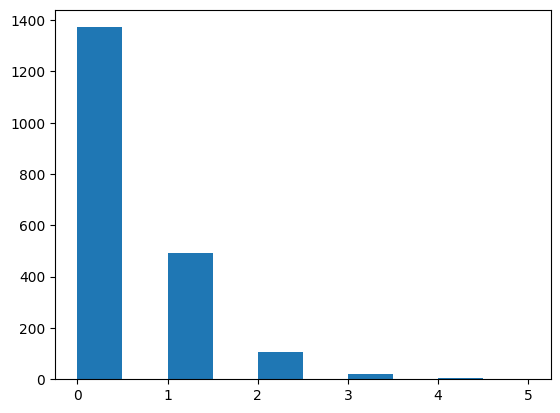

In [15]:
G_filtered.degree()
d_degree = dict(G_filtered.degree())
n, bins, patches = plt.hist(d_degree.values())
plt.show() #la majorité des articles ont un degré faible avant un fort nombre de noeuds isolés

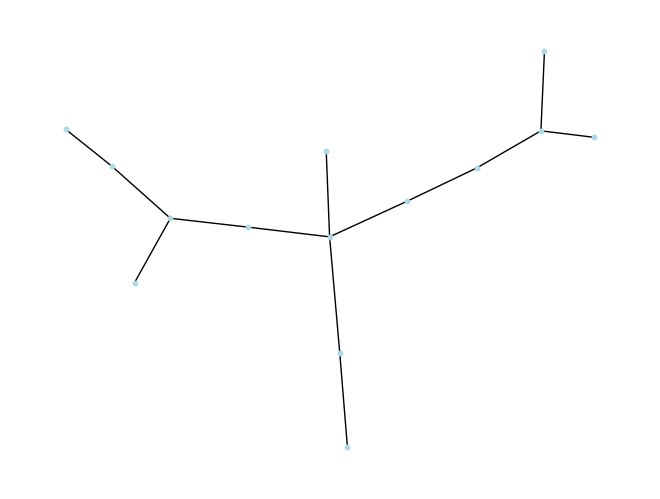

In [16]:
#Affichage du plus grand composant connexe
g_sorted = sorted(nx.connected_components(G_filtered), key=len, reverse=True)

g = G_filtered.subgraph(g_sorted[0])
pos = nx.spring_layout(g)
nx.draw(g, pos, with_labels=False, node_size=10, node_color='lightblue', font_size=8)
plt.show()

#### Centrality Measures

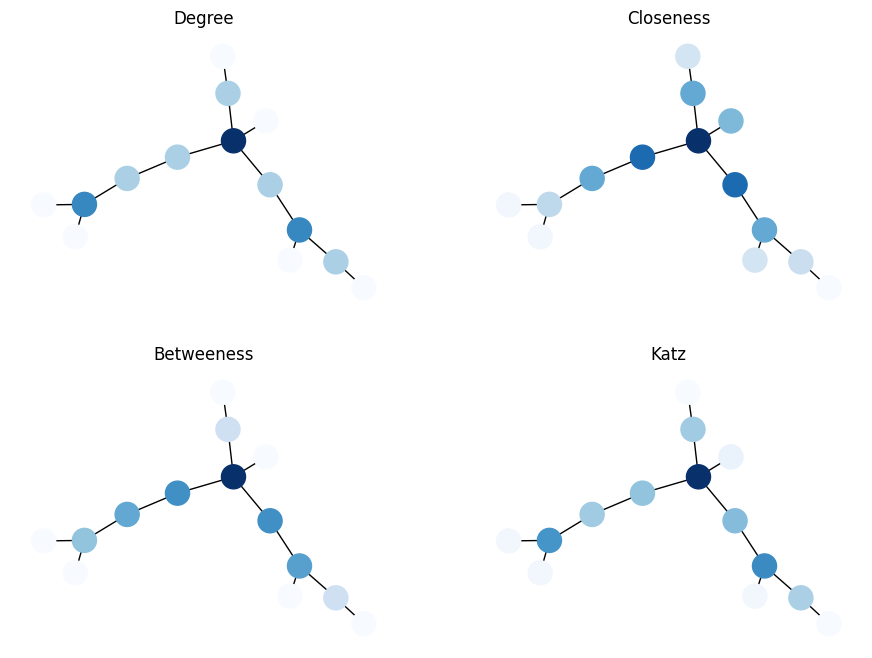

In [17]:
#On affiche les centralités des noeuds du graphe des articles
centralities = [nx.degree_centrality, nx.closeness_centrality, nx.betweenness_centrality, nx.katz_centrality]
centralities_names = ["Degree", "Closeness", "Betweeness", "Katz"]
val_cent = []

for c in centralities:
    val_cent.append(c(g))

my_pos = nx.spring_layout(g)

figure = plt.figure(figsize=(11, 8))
for i in range(len(centralities)):
    figure.add_subplot(2, 2, i+1)
    plt.title(centralities_names[i])
    nx.draw(g, pos = my_pos, with_labels=False, node_color=[*val_cent[i].values()], cmap=plt.cm.Blues)
plt.show()

## Search Engine

### Preprocessing

In [19]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PXDD4216\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PXDD4216\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PXDD4216\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
##Nombre de Nan dans les abstracts
print("Number of NAN abstracts", corpus['abstract'].isna().sum())

##On les retire
corpus = corpus.dropna(subset=['abstract'])

Number of NAN abstracts 34037


In [21]:
#Création d'une fonction de prétraitement des abstracts
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    tokens = [stemmer.stem(t) for t in tokens]
    return " ".join(tokens)

corpus['abstract'] = corpus['abstract'].apply(preprocess)

### Vectorization

In [22]:
#On affiche les mots les plus fréquents
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000)
X = vectorizer.fit_transform(corpus['abstract'])
features_hp = vectorizer.get_feature_names_out()

In [23]:
from scipy.sparse import find, csr_matrix
import pandas as pd

# cette fonction permet d'afficher une "jolie" représentation du vecteur v
# ARGS :
#   v : le vecteur à afficher (par ex. une ligne de la matrice X)
#   features : le vocabulaire
#   top_n : le nombre de mots maximum à afficher
def print_feats(v, features, top_n = 30):
    _, ids, values = find(v)
    feats = [(ids[i], values[i], features[ids[i]]) for i in range(len(list(ids)))]
    top_feats = sorted(feats, key=lambda x: x[1], reverse=True)[0:top_n]
    return pd.DataFrame({"word" : [t[2] for t in top_feats], "value": [t[1] for t in top_feats]})  

In [24]:
n_docs, n_terms = X.shape

# on fait la somme sur toutes les lignes pour chacun des mots
tf_sum = X.sum(axis=0)
tf_sum = tf_sum.tolist()[0] # conversion en liste

print_feats(tf_sum, features_hp)

word  value
0         use  46895
1      propos  37034
2       model  32944
3      system  32247
4        data  30924
5      method  29521
6       paper  28360
7      result  27070
8   algorithm  24702
9     network  24259
10    perform  22910
11       base  21848
12    problem  20036
13   approach  18689
14       show  18309
15    present  16742
16      studi  15917
17       time  15703
18     differ  15503
19     comput  15299
20     inform  15274
21     provid  14925
22     design  14307
23    process  13938
24       user  13899
25     applic  13875
26    develop  13414
27       also  13094
28       imag  13045
29      optim  12587

In [25]:
from scipy.linalg import norm

# fonction calculant le cosinus entre deux vecteurs
def cosinus(i, j):
        # numérateur : <i.j>
    num = i.dot(j.transpose())[0,0]
        # dénominateur : ||i||_2 * ||j||_2
    den = norm(i.todense()) * norm(j.todense())
    if (den>0): # on vérifie que le dénominateur n'est pas nul
        return (num/den)
    else:
        return 0

In [26]:
print(print_feats(X[5], features_hp, top_n=30))
print('----------------------------------------')
print(print_feats(X[10], features_hp, top_n=30))

          word  value
0         text      6
1      contain      5
2     recognit      5
3       result      3
4         code      2
5       detect      2
6    dimension      2
7      identif      2
8       propos      2
9         rate      2
10      achiev      1
11       addit      1
12     automat      1
13  background      1
14        base      1
15        bodi      1
16    challeng      1
17       color      1
18      compon      1
19     connect      1
20     coverag      1
21    demonstr      1
22       error      1
23        even      1
24  experiment      1
25        form      1
26     generat      1
27      global      1
28        high      1
29        make      1
----------------------------------------
             word  value
0        approach      3
1          method      3
2          appear      2
3          compar      2
4          record      2
5             use      2
6         variant      2
7          applic      1
8         complex      1
9        demonstr      1
10

In [27]:
similarity_5_10 = round(cosinus(X[5], X[10]) * 100,2)
print("Similarity between 5 and 10 : ", similarity_5_10, "%")

Similarity between 5 and 10 :  4.02 %


#### TF-IDF

In [28]:
# Vectorisation des abstracts
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(corpus['abstract'])
features_hp = vectorizer.get_feature_names_out()

n_docs, n_terms = X.shape

In [29]:
# similarité entre les documents
def similarity(input, X):
    input = preprocess(input)
    input = vectorizer.transform([input])
    sim = []
    for i in range(n_docs):
        sim.append(cosinus(input, X[i]))
    return sim

In [30]:
def most_similar(input, X, corpus, top_n=10):    
    sim = similarity(input, X)
    sim_sorted = sorted(enumerate(sim), key=lambda x: x[1], reverse=True)
    for i in range(top_n):
        print("Document ", sim_sorted[i][0], " : ", corpus['title'].iloc[sim_sorted[i][0]], " (", round(sim_sorted[i][1],2)*100, "%)")

In [31]:
# Affichage des documents les plus similaires par rapport à 'Machine Learning'
most_similar("machine learning", X, corpus, top_n=10)

Document  4173  :  On the feasibility of an embedded machine learning processor for intrusion detection  ( 72.0 %)
Document  44550  :  Infrastructure for Usable Machine Learning: The Stanford DAWN Project  ( 64.0 %)
Document  27692  :  Machine learning and systems for the next frontier in formal verification  ( 63.0 %)
Document  28972  :  The 2003 learning classifier systems bibliography  ( 63.0 %)
Document  27044  :  Hyperparameter optimization to improve bug prediction accuracy  ( 62.0 %)
Document  2985  :  Machine Learning Meets Databases  ( 61.0 %)
Document  34438  :  In vitro molecular machine learning algorithm via symmetric internal loops of DNA  ( 61.0 %)
Document  42712  :  The optimal crowd learning machine  ( 59.0 %)
Document  30622  :  Design and implementation of low-level machine learning API and API server  ( 56.99999999999999 %)
Document  12814  :  Ontology knowledge-based framework for machine learning concept  ( 56.99999999999999 %)


#### Doc2Vec

In [32]:
#Utilisation de Doc2Vec pour trouver les documents les plus similaires à la recherche
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

min_docs = 4
tagged_docs = []
nbw_docs = []

for i, abstract in enumerate(corpus['abstract']):
    if len(abstract.split()) > min_docs:
        tagged_docs.append(TaggedDocument(words=word_tokenize(abstract), tags=[i]))
        nbw_docs.append(len(abstract.split()))

In [44]:
len(tagged_docs)
tagged_docs[0:4]

[TaggedDocument(words=['adaboost', 'algorithm', 'base', 'haarlik', 'featur', 'achiev', 'high', 'accuraci', '95', 'object', 'detect', 'meanwhil', 'massiv', 'comput', 'power', 'need', 'implement', 'cascad', 'classifi', 'involv', 'adaboost', 'detect', 'solv', 'problem', 'sever', 'dedic', 'hardwar', 'solut', 'propos', 'realtim', 'applic', 'work', 'novel', 'heterogen', 'architectur', 'adaboost', 'detector', 'present', 'architectur', 'achiev', 'higher', 'perform', 'consum', 'fewer', 'hardwar', 'resourc', 'combin', 'integr', 'arm', 'cortexa9', 'processor', 'dedic', 'acceler', 'architectur', 'configur', 'realiz', 'various', 'object', 'detect', 'simpli', 'load', 'differ', 'paramet', '2d', 'parallel', 'involv', 'acceler', 'unit', 'combin', 'bring', 'flexibl', 'scheme', 'implement', 'xilinx', 'zc702', 'platform', 'experi', 'result', 'show', '40', 'qvga', 'frame', 'per', 'second', 'achiev', 'realtim', 'face', 'detect', 'acceler', 'achiev', '13', 'time', 'improv', 'opencv', 'implement', 'standalon'

In [33]:
#Création du modèle Doc2Vec
dim_d2v = 10

model_doc2vec = Doc2Vec(tagged_docs, vector_size=dim_d2v, window=3, epochs=50)
model_doc2vec.train(tagged_docs, total_examples=model_doc2vec.corpus_count, epochs=model_doc2vec.epochs)

In [34]:
#Test avec la recherche "data"
test_doc = word_tokenize("data".lower())
test_doc_vector = model_doc2vec.infer_vector(test_doc)
res = model_doc2vec.dv.most_similar(positive = [test_doc_vector])
print(res)

[(42198, 0.81707763671875), (32910, 0.7629196643829346), (7123, 0.7601826190948486), (25135, 0.7384929060935974), (44530, 0.7249670624732971), (1950, 0.7234386205673218), (43137, 0.7133923768997192), (37861, 0.7046995162963867), (23990, 0.6953397393226624), (15106, 0.6944429278373718)]


In [35]:
for i in range(10):
    print("Document ", res[i][0], " : ", corpus['title'].iloc[res[i][0]], " (", round(res[i][1],2)*100, "%)")

Document  42198  :  Modeling pressure drop produced by different filtering media in microirrigation sand filters using the hybrid ABC-MARS-based approach, MLP neural network and M5 model tree  ( 82.0 %)
Document  32910  :  Performance Evaluation of Multiple Cloud Data Centers Allocations for HPC  ( 76.0 %)
Document  7123  :  Multi-resident activity tracking and recognition in smart environments  ( 76.0 %)
Document  25135  :  A service computing manifesto: the next 10 years  ( 74.0 %)
Document  44530  :  A multi-scale deep quad tree based feature extraction method for the recognition of isolated handwritten characters of popular indic scripts  ( 72.0 %)
Document  1950  :  Materialized view selection in feed following systems  ( 72.0 %)
Document  43137  :  Guest Editors' Introduction: Ad Hoc Networks  ( 71.0 %)
Document  37861  :  An aggregation and visualization technique for crowd-sourced continuous monitoring of transport infrastructures  ( 70.0 %)
Document  23990  :  An approach to o

In [36]:
def most_similar_doc2vec(input, model, corpus, top_n=10):
    test_doc = word_tokenize(input.lower())
    test_doc_vector = model.infer_vector(test_doc)
    res = model.dv.most_similar(positive = [test_doc_vector])
    for i in range(top_n):
        print("Document ", res[i][0], " : ", corpus['title'].iloc[res[i][0]], " (", round(res[i][1],2)*100, "%)")

In [37]:
#Importation des librairies nécessaires pour S-BERT
import torch # the main pytorch library
import torch.nn.functional as f # the sub-library containing different functions for manipulating with tensors

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [38]:
#Utilisation de S-BERT pour trouver les documents les plus similaires à la recherche
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
model = model.to(device)

bert_abstract = corpus['abstract'].apply(lambda x: x[:512])

# keep a quarter of the abstracts because of a poptato computer
bert_abstract = bert_abstract.sample(frac=0.25)

embeddings = model.encode(bert_abstract.values, convert_to_tensor=True)

In [39]:
#Calcul de la similarité cosinus avec embeddings de S-BERT
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity_matrix = cosine_similarity(embeddings, embeddings)

def most_similar_bert(input, embeddings, top_n=10):
    input = model.encode([input], convert_to_tensor=True)
    sim = cosine_similarity(input, embeddings)
    sim_sorted = sorted(enumerate(sim[0]), key=lambda x: x[1], reverse=True)
    for i in range(top_n):
        print("Document ", sim_sorted[i][0], " : ", bert_abstract.iloc[sim_sorted[i][0]][0:100], " (", round(sim_sorted[i][1],2)*100, "%)")

most_similar_bert("data", embeddings, top_n=10)

Document  8294  :  human expert amount sensori data deal moment human brain analysi data also start synthes new inform   ( 54.00000214576721 %)
Document  11106  :  abil synthes sensori data preserv specif statist properti real data tremend implic data privaci big   ( 51.99999809265137 %)
Document  5688  :  new valu extract manag analyz huge volum data big data paradigm paradigm data environ public data da  ( 50.999999046325684 %)
Document  10900  :  amount current produc data emphas import techniqu effici data process search big data collect accord  ( 50.0 %)
Document  2801  :  develop data scienc market data also play signific role data mine domain gradual paper focus use vis  ( 50.0 %)
Document  11184  :  amount data extract learn experi grown astonish pace depth due increas varieti data sourc breath cou  ( 50.0 %)
Document  4836  :  smartphon revolution way infrastructur health monitor applic oper ubiquit sens communic capabl made   ( 50.0 %)
Document  3057  :  open data tremend pot

#### Playground

In [66]:
search = "network"
algo = "Doc2Vec"
top_n = 10

In [67]:
if algo == "TFIDF":
    most_similar(search, X, corpus, top_n)
elif algo == "Doc2Vec":
    most_similar_doc2vec(search, model_doc2vec, corpus, top_n)
elif algo == "SBERT":
    most_similar_bert(search, embeddings, top_n)
else:
    print("Invalid algorithm")

Document  591  :  Hierarchical Cluster Configuration Scheme for Scalable Ad Hoc Networks  ( 84.0 %)
Document  30402  :  An efficient and fast kinematics-based algorithm for RFID network planning  ( 84.0 %)
Document  24387  :  Enhancing performance and longevity of multi-radio multi-channel hetnets through dynamic path-assignment  ( 81.0 %)
Document  40203  :  Signalling concepts in heterogeneous IP multi-domains networks  ( 81.0 %)
Document  36375  :  Node ranking in wireless sensor networks with linear topology  ( 81.0 %)
Document  12063  :  Research on network fault tolerance method on chip  ( 80.0 %)
Document  11789  :  Intelligent dynamic Connectivity Control Algorithm for cluster-based wireless sensor networks  ( 80.0 %)
Document  11718  :  Maximizing the wireless sensor networks lifetime  ( 80.0 %)
Document  42950  :  Integration of metric place relations in a landmark graph  ( 80.0 %)
Document  25135  :  A service computing manifesto: the next 10 years  ( 79.0 %)


## Classification

In [73]:
#Création d'une fonction pour la recherche de documents
import numpy as np

corpus['venue'].replace('', np.nan, inplace=True)
corpus = corpus.dropna(subset=['venue'])

stop_words_venues = [
    "applied",
    "arxiv",
    "conference",
    "information",
    "international",
    "journal",
    "knowledge",
    "research",
    "symposium",
    "acm",
    "advances",
    "lectures",
    "notes",
    "note"
]

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [t for t in tokens if t not in stop_words_venues]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    tokens = [stemmer.stem(t) for t in tokens]
    return " ".join(tokens)

corpus['venue'] = corpus['venue'].apply(preprocess)
    
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus['venue'])
features_venues = vectorizer.get_feature_names_out()

n_docs, n_terms = X.shape

# on fait la somme sur toutes les lignes pour chacun des mots
tf_sum = X.sum(axis=0)
tf_sum = tf_sum.tolist()[0] # conversion en liste

print_feats(tf_sum, features_venues)

word  value
0      comput  11099
1      scienc   5323
2      lectur   3633
3      system   3538
4    communic   2911
5        ieee   2700
6     network   1822
7     pattern   1505
8    recognit   1503
9       engin   1477
10     applic   1459
11  technolog   1349
12   transact   1302
13    process   1257
14     vision   1172
15      robot   1164
16       data   1056
17     theori   1038
18   intellig   1034
19   mathemat   1004
20      learn    994
21   wireless    962
22     global    955
23   cybernet    939
24     sensor    903
25     design    871
26      autom    818
27     signal    749
28        man    743
29   informat    741

<Axes: xlabel='category'>

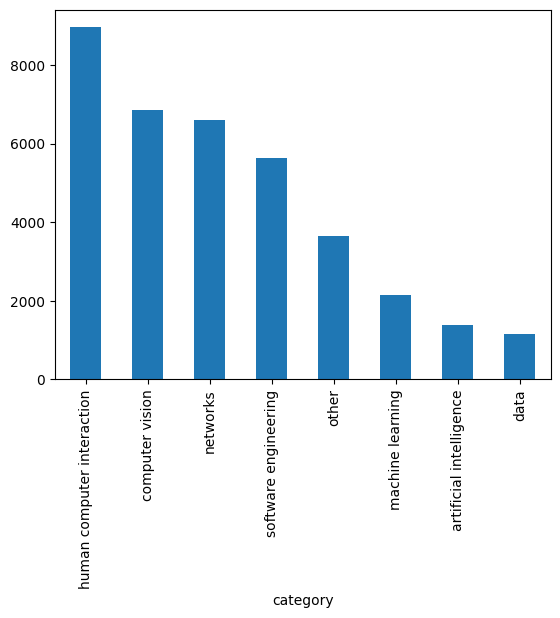

In [74]:
categories = {
    "artificial intelligence" : ["artifici","intellig", "theori", "electron"],
    "computer vision": ["comput", "imag","ieee", "manag", "design", "vision", "recognit", "pattern"],
    "data" : ["data", "analysi", "transact"],
    "human computer interaction": ["communic","robot", "scienc", "human", "sensor"],
    "machine learning": ["model","mathemat", "language", "logic", "algorithm", "learn"],
    "networks": ["network", "system", "process", "secur","wireless","cybernet"],
    "software engineering": ["engin", "technolog", "applic", "softwar", "program", "informat"]
}

#On crée une nouvelle colonne pour les catégories
corpus["category"] = ""

for category, keywords in categories.items():
    for keyword in keywords:
        corpus.loc[corpus['venue'].str.contains(keyword), "category"] = category

#On remplace les valeurs manquantes par "other"
corpus["category"].replace("", "other", inplace=True)

corpus["category"].value_counts().sum()
corpus["category"].value_counts().plot(kind='bar')


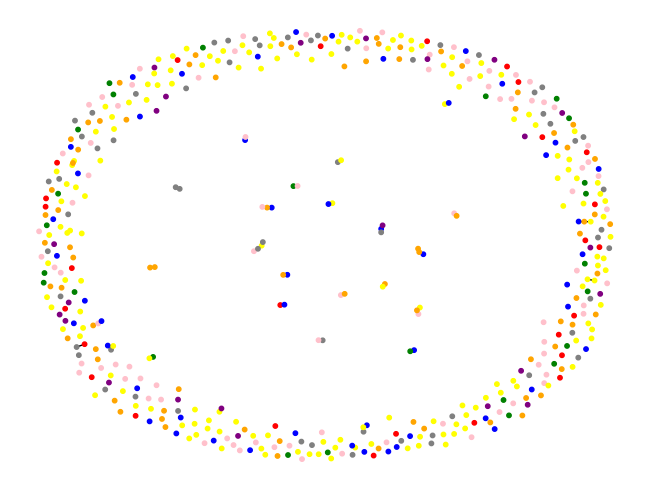

In [42]:
#Affichage du graphe des articles par catégorie générée
from random import randint
mpld3.enable_notebook()
G = nx.Graph()
NB_NODES = 500

for index, row in corpus.iterrows():
    G.add_node(row['id'], category=row['category'])

for index, row in corpus.iterrows():
    for ref in row['references']:
        if ref in G.nodes():
            G.add_edge(row['id'], ref)

categories_color = {
    "artificial intelligence": "red",
    "computer vision": "blue",
    "data": "green",
    "human computer interaction": "yellow",
    "machine learning": "purple",
    "networks": "orange",
    "software engineering": "pink",
    "other": "grey"
}

sub_G = G.subgraph(list(G.nodes())[:NB_NODES])

# # # create a color map for the nodes
color_map = []

for node in sub_G:
    node_category = sub_G.nodes[node]['category']
    color_map.append(categories_color[node_category])

# # # draw the graph
pos = nx.spring_layout(sub_G)
nx.draw(sub_G, pos, node_color=color_map, with_labels=False, node_size=10)

plt.show()

### Classification of Documents

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(corpus['abstract'], corpus['category'], test_size=0.3, random_state=42)

BERT or TF-IDF, exec the one your pc can handle...

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

X_train = model.encode(X_train.values)
X_test = model.encode(X_test.values)

In [73]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(corpus['abstract'])

X_train, X_test, y_train, y_test = train_test_split(X, corpus['category'], test_size=0.3, random_state=42)

In [74]:
X_train

<25511x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1255453 stored elements in Compressed Sparse Row format>

In [75]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy Logistic Regression : ", acc)

Accuracy Logistic Regression :  0.3741540149990854


In [76]:
from sklearn.svm import SVC

model = SVC(kernel='poly', degree=2)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy SVM : ", acc)

Accuracy SVM :  0.3944576550210353


In [77]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(solver='adam', alpha=1e-5, max_iter=500)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy MLP : ", acc)

Accuracy MLP :  0.3231205414304006


In [43]:
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv

import torch.nn.functional as F
from tqdm import tqdm

In [44]:
# convert networkx graph to pytorch geometric graph
from torch_geometric.utils import convert

# add embeddings to the graph named "x"
for index, row in corpus.iterrows():
    if row['id'] in sub_G.nodes():
        sub_G.nodes[row['id']]['x'] = embeddings[index]
data = convert.from_networkx(sub_G)
data.y = data.category

del data.category
del data.embeddings

# create a mask for the train, validation and test set
train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

train_mask[:int(data.num_nodes*0.8)] = 1
val_mask[int(data.num_nodes*0.8):int(data.num_nodes*0.9)] = 1
test_mask[int(data.num_nodes*0.9):] = 1

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

In [45]:
# label encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data.y = le.fit_transform(np.array(data.y).reshape(-1, 1))

# convert data.y to tensor
data.y = torch.tensor(data.y, dtype=torch.long)

In [46]:
def print_accuracy(nom_algo, truth_train, pred_train, truth_test, pred_test):
    print(nom_algo + " : ")
    acc_app = np.sum(pred_train == truth_train) / float(len(pred_train))
    print(f"  - réussite (accuracy) apparente : {acc_app:.1%}")
    acc_gen = np.sum(pred_test == truth_test) / float(len(pred_test))
    print(f"  - réussite (accuracy) en généralisation : {acc_gen:.1%}")    

In [47]:
class MyGCN(torch.nn.Module):
    def __init__(self, d, n_feat):
        super().__init__()
        self.d = d
        # Initialisation des couches de convolutions
        self.conv1 = GCNConv(n_feat, 16)        
        self.conv2 = GCNConv(16, corpus['category'].nunique())

    def forward(self):
        # Récupération des données
        x, edge_index, edge_attr = self.d, data.edge_index, data.edge_attr
        # Premiere convolution
        x = F.dropout(x, training=self.training)
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        # Deuxième convolution
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        # Softmax
        return F.log_softmax(x, dim=1)

In [48]:
class Training():
    
    def __init__(self, m, o):
        self.model = m
        self.optim = o
    
    def train(self, nb_epochs=50):
        progress_bar = tqdm(range(nb_epochs))
        for epoch in progress_bar:
            train_acc, test_acc = self.test()
            progress_bar.set_description(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Test: {test_acc:.4f}')        
            self.model.train() ## mode "train"
            self.optim.zero_grad()
            F.nll_loss(self.model()[data.train_mask], data.y[data.train_mask]).backward()
            self.optim.step()
        
    def eval(self):
        self.model.eval()
        
    def forward(self):
        return self.model.forward()

    # retourne l'accuracy sur les données d'entraînement (train) et sur le test
    @torch.no_grad()
    def test(self):
        self.model.eval()  ## mode "eval" (pas de dropout)
        log_probs, accs = self.model(), []
        for _, mask in data('train_mask', 'test_mask'):
            pred = log_probs[mask].max(1)[1]
            acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
            accs.append(acc)
        return accs
    
    @torch.no_grad()
    def print_eval(self, name):
        self.model.eval()  ## mode "eval" (pas de dropout)        
        log_probs = self.model()
        pred_train = np.array(log_probs[data.train_mask].max(1)[1])
        pred_test = np.array(log_probs[data.test_mask].max(1)[1])
        print_accuracy(name, data.y[data.train_mask].tolist(), pred_train, data.y[data.test_mask].tolist(), pred_test)

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_GCN1, data = MyGCN(data.x, data.num_features).to(device), data.to(device) # Chargement du modèle et des données en mémoire (VRAM ou RAM en fonction de la présence ou non d'un gpu)
optimizer_GCN1 = torch.optim.Adam(model_GCN1.parameters(), lr=0.01, weight_decay=5e-3)    

In [50]:
m1 = Training(model_GCN1, optimizer_GCN1)
m1.train(nb_epochs=200)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 199, Train: 0.5575, Test: 0.3200: 100%|██████████| 200/200 [00:02<00:00, 84.92it/s]


In [51]:
m1.print_eval("GCN with features")

GCN with features : 
  - réussite (accuracy) apparente : 55.0%
  - réussite (accuracy) en généralisation : 32.0%


In [52]:
class MyGAT(torch.nn.Module):
    def __init__(self, d, n_feat):
        super().__init__()
        self.d = d
        # Initialisation des couches de convolutions
        self.conv1 = GATConv(n_feat, 16)
        self.conv2 = GATConv(16, corpus['category'].nunique())

    def forward(self):
        # Récupération des données
        x, edge_index, edge_attr = self.d, data.edge_index, data.edge_attr
        # Premiere convolution
        x = F.dropout(x, training=self.training)
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        # Deuxième convolution
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        # Softmax
        return F.log_softmax(x, dim=1)

In [54]:
modelGATv1, data = MyGAT(data.x, data.num_features).to(device), data.to(device) # Chargement du modèle et des données en mémoire (VRAM ou RAM en fonction de la présence ou non d'un gpu)
optimizerGATv1 = torch.optim.Adam(modelGATv1.parameters(), lr=0.01, weight_decay=5e-3) 
m4 = Training(modelGATv1, optimizerGATv1)
m4.train()
m4.print_eval("GATv1")

Epoch: 049, Train: 0.4025, Test: 0.2800: 100%|██████████| 50/50 [00:01<00:00, 32.73it/s]

GATv1 : 
  - réussite (accuracy) apparente : 40.2%
  - réussite (accuracy) en généralisation : 28.0%


In [55]:
class MyGATv2(torch.nn.Module):
    def __init__(self, d, n_feat):
        super().__init__()
        self.d = d
        # Initialisation des couches de convolutions
        self.conv1 = GATv2Conv(n_feat, 6, heads=4) # on essaie d'utiliser 4 têtes d'attention ici
        self.conv2 = GATv2Conv(24, corpus['category'].nunique())

    def forward(self):
        # Récupération des données
        x, edge_index, edge_attr = self.d, data.edge_index, data.edge_attr
        # Premiere convolution
        x = F.dropout(x, training=self.training)
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        # Deuxième convolution
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        # Softmax
        return F.log_softmax(x, dim=1)

In [56]:
modelGATv2, data = MyGATv2(data.x, data.num_features).to(device), data.to(device) # Chargement du modèle et des données en mémoire (VRAM ou RAM en fonction de la présence ou non d'un gpu)
optimizerGATv2 = torch.optim.Adam(modelGATv2.parameters(), lr=0.01, weight_decay=5e-3) 
m5 = Training(modelGATv2, optimizerGATv2)
m5.train()
m5.print_eval("GATv2")

Epoch: 049, Train: 0.4125, Test: 0.3200: 100%|██████████| 50/50 [00:00<00:00, 54.21it/s]

GATv2 : 
  - réussite (accuracy) apparente : 41.8%
  - réussite (accuracy) en généralisation : 32.0%


## Clustering

In [76]:
#spectral clustering with S-BERT
from sklearn.cluster import SpectralClustering
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

embeddings = model.encode(corpus['abstract'].values[:2500], convert_to_tensor=True) #on a réduit le nombre de documents pour des raisons de temps de calcul

sc = SpectralClustering(n_clusters=8, affinity='nearest_neighbors', n_neighbors=10)
sc.fit(embeddings)


SpectralClustering(affinity='nearest_neighbors')

In [79]:
#calculs ari et ami pour kmeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

corpus['categories'] = pd.Categorical(corpus['category'])
corpus['categories'] = corpus['categories'].cat.codes

ari = adjusted_rand_score(sc.labels_, corpus['categories'].values[:2500])
ami = adjusted_mutual_info_score(sc.labels_, corpus['categories'].values[:2500])

print("ARI : ", ari)
print("AMI : ", ami)

ARI :  0.004962295674692511
AMI :  0.05603659909547882


In [90]:
# Vectorisation des abstracts
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(corpus['abstract'].values[:3500])

In [91]:
#spectral clustering avec TFxIDF
clustering = SpectralClustering(n_clusters=8, assign_labels="discretize", random_state=0)

clustering.fit(X)

SpectralClustering(assign_labels='discretize', random_state=0)

In [92]:
ari = adjusted_rand_score(clustering.labels_, corpus['categories'].values[:3500])
ami = adjusted_mutual_info_score(clustering.labels_, corpus['categories'].values[:3500])

print("ARI : ", ari)
print("AMI : ", ami)

ARI :  0.02174584313625057
AMI :  0.05667588784630196


In [57]:
#Création du modèle Doc2Vec
dim_d2v = 10

model_doc2vec = Doc2Vec(tagged_docs, vector_size=dim_d2v, window=3, epochs=50)
model_doc2vec.train(tagged_docs, total_examples=model_doc2vec.corpus_count, epochs=model_doc2vec.epochs)

In [93]:
#clustering kmeans with doc2Vec
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=8, random_state=0).fit(model_doc2vec.dv.vectors)


In [98]:
kmeans.labels_ = kmeans.labels_[:len(corpus['categories'])] #on fait matcher les labels avec les catégories
ari = adjusted_rand_score(kmeans.labels_, corpus['categories'])
ami = adjusted_mutual_info_score(kmeans.labels_, corpus['categories'])

print("ARI : ", ari)
print("AMI : ", ami)

ARI :  0.00011077108404492105
AMI :  0.00014274193181150282


In [85]:
#clustering KMeans avec TFxIDF
kmeans = KMeans(n_clusters=8, random_state=0).fit(X)

corpus['cluster'] = kmeans.labels_

corpus['cluster'].value_counts()

cluster
7    10808
0     7868
5     3806
6     3379
2     3263
3     2814
4     2736
1     1758
Name: count, dtype: int64

In [86]:
#Catégorie majoritaire pour chaque cluster
for i in range(8):
    print("Cluster ", i, " : ", corpus[corpus['cluster'] == i]['category'].value_counts().idxmax())

Cluster  0  :  human computer interaction
Cluster  1  :  computer vision
Cluster  2  :  networks
Cluster  3  :  human computer interaction
Cluster  4  :  networks
Cluster  5  :  computer vision
Cluster  6  :  human computer interaction
Cluster  7  :  human computer interaction


In [87]:
#Calcul des scores ARI et AMI
print("adjusted rand score :", adjusted_rand_score(corpus['cluster'], corpus['category']))
print("adjusted mutual info score :", adjusted_mutual_info_score(corpus['cluster'], corpus['category']))

adjusted rand score : 0.007847251747093638
adjusted mutual info score : 0.025832230891901228


In [ ]:
#Specral clustering with doc2vec
scdoc = SpectralClustering(n_clusters=8, affinity='nearest_neighbors', n_neighbors=10)
scdoc.fit(model_doc2vec.dv.vectors)

In [ ]:
#Test avec les blocks models
from sklearn.cluster import AgglomerativeClustering

X = X.toarray()
clustering = AgglomerativeClustering(n_clusters=8).fit(X)

corpus['cluster'] = clustering.labels_

corpus['cluster'].value_counts()